In [10]:
import datetime as dt
import os
import utils as cu
import pandas as pd
from geopy.distance import great_circle as gdist
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import netCDF4 as nc4
# import parameters as params
import glob
from scipy.interpolate import interp1d
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize


# from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# from matplotlib.cbook import get_sample_data

from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.image as mpimg

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/disk/p/jkcm/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:

def final_traj_plot(flightname, tlist, labels, out_fp, ret_fp, outfile,
                    ret_waypts, ret_labels, wplab):

    def plot_single(t, m=None, c=None, i=None):
        m.plot(t.lon.values, t.lat.values, c=c, latlon=True, label=t.tnum[0])
        m.plot(t.lon.values[::6], t.lat.values[::6], '.', c=c, latlon=True)
        m.plot(t.lon.values[0], t.lat.values[0], '*', c=c, latlon=True, ms=8)
        if i is not None:
            x, y = m(t.lon.values[0]-.5, t.lat.values[0]+.5)
            ax.annotate(labels[i], xy=(x, y), xytext=(x, y), xycoords='data',
                        textcoords='data', fontsize=9, color='w',
                        backgroundcolor=(0, 0, 0, 0.85))
        return m

    # setting up colormaps
    cdict1 = {'red':   ((0.0, 0.0, 0.0), (0.5, 1.0, 1.0), (1.0, 1.0, 1.0)),
              'green': ((0.0, 0.0, 0.0), (0.5, 1.0, 1.0), (1.0, 0.0, 0.0)),
              'blue':  ((0.0, 0.0, 1.0), (0.5, 0.0, 0.0), (1.0, 0.0, 0.0)),
              'alpha': ((0.0, 0.5, 0.5), (1.0, 0.5, 0.5))}
    cdict2 = {'red':   ((0.0, 0.0, 0.0), (0.4, .97, .97), (1.0, 0.0, 0.0)),
              'green': ((0.0, .72, .72), (0.4, .63, .63), (1.0, 0.0, 0.0)),
              'blue':  ((0.0, .92, .92), (0.4, .12, .12), (1.0, 0.0, 0.0)),
              'alpha': ((0.0, 1.0, 1.0), (1.0, 1.0, 1.0))}
    cm_BR = LinearSegmentedColormap('BlueRed1', cdict1, N=19)
    cm_alt = LinearSegmentedColormap('custom2', cdict2, N=100)

    # initializing figure
    fig = plt.figure(figsize=(4.5, 5))
    cax2 = fig.add_axes([.06, 0.11, .88, 0.04])
    ax = fig.add_axes([0.060, 0.14, .88, 0.88])
    if wplab == 'b':
        cax1 = fig.add_axes([.06, 0.06, .88, 0.04])
    m = cu.bmap(ax=ax)

    # setting up dataframe of tdumps
    T = pd.DataFrame()
    for i, tdump in enumerate(tlist):
        tdf = cu.read_tdump(tdump)
        tdf.tnum = i+1
        T = pd.concat([T.sort_index(), tdf[0:59]])
    t = T.groupby('tnum')

    # plotting trajectories
    colors = cm.rainbow(np.linspace(0, 1, len(list(t.groups.keys()))))
    for i, k in enumerate(t.groups.keys()):
            m = plot_single(t.get_group(k), m=m, c=colors[i], i=i)

    # adding great circle, start and end
    m.drawgreatcircle(-121.3, 38.6, -156, 19.8, ls='--', c='k', alpha=0.8)
    m.plot(-121.3, 38.6, 's', ms=8, c='black')
    m.plot(-156, 19.8, '*', ms=12, c='black')

    # adding outbound and return flight
    norm = Normalize(vmin=300, vmax=5000)
    points = np.array([out_fp['lons'], out_fp['lats']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cm_alt, norm=norm)
    lc.set_array(out_fp['alt'])
    lc.set_linewidth(3)
    ax.add_collection(lc)

    points = np.array([ret_fp['lons'], ret_fp['lats']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cm_alt, norm=norm)
    lc.set_array(ret_fp['alt'])
    lc.set_linewidth(3)
    ax.add_collection(lc)

    # adding return labels
    for i, wp in enumerate(ret_waypts):
        x = wp[1]+0.3
        y = wp[0]-0.8
        bcg = dist_2_col(wp[3], cm_BR) if wplab == 'b' else (0.74, 0, 0, 0.5)
        ax.annotate(ret_labels[i]+wplab, xy=(x, y), xytext=(x, y),
                    xycoords='data',
                    fontsize=9, backgroundcolor=bcg)
        m.plot(wp[1], wp[0], '.', ms=7, c='black')

    # adding legend and colorbar
    if wplab == 'b':
        X, Y = np.meshgrid(np.arange(20), np.array([0, 1]))
        Z = np.array([np.linspace(0, 100, 20)])
        ax2 = m.pcolor(X, Y, Z, cmap=cm_BR)
        cb = fig.colorbar(ax2, cax=cax1, cmap=cm_BR, orientation='horizontal',
                          drawedges=False)
        cb.set_label(r"Distance between plane and airmass at 'b' waypoint (km)")
        cb.solids.set_edgecolor('none')
    cb2 = fig.colorbar(lc, cax=cax2, cmap=cm_alt, orientation='horizontal',
                       drawedges=False)
    cb2.ax.xaxis.set_ticks_position('top')
    cb2.ax.xaxis.set_label_position('top')
    cb2.set_label(r'Plane altitude (m)')

    # adding title and saving figure
    eggs = 'red' if wplab == 'a' else 'colored'
#    plotname = '{} trajectories and flight paths\nblack'.format(flightname) +\
#               ' labels mark outbound flight, {} labels mark '.format(eggs) +\
#               'return flight (\textbf\{{{} waypoints\}})'.format(wplab)
    plotname = '{} trajectories and flight paths'.format(tform(flightname)) +\
               '\nblack' +\
               ' labels mark outbound flight, {} labels mark '.format(eggs) +\
               r'return flight (\textbf{{{} waypoints}})'.format(wplab)

    ax.set_title(plotname, y=1.05)
    print(outfile)
#     fig.savefig(outfile, dpi=300)
#     fig.clf()
#     plt.close('all')
    return fig


def read_a_waypt(flightplan, floc):
    """read in 'a' style waypoints"""
    name = flightplan['name']
    infile = os.path.join(floc, '{}_a_waypoints.txt'.format(name.upper()))
    with open(infile, 'r') as f:
        lines = f.readlines()
        labels = []
        a_waypts = []
        for line in lines[4:-1]:
            vlst = line.split()
            labels.append(vlst[0])
            date = dt.datetime(*[int(i) for i in vlst[10:15]])
            a_waypts.append((float(vlst[8]), float(vlst[9]), date))
    return labels, a_waypts


def read_b_waypt(flightplan, floc):
    """read in 'b' style waypoints"""
    name = flightplan['name']
    infile = os.path.join(floc, '{}_b_waypoints.txt'.format(name.upper()))
    with open(infile, 'r') as f:
        lines = f.readlines()
        labels = []
        b_waypts = []
        for line in lines[3:]:
            vlst = line.split()
            labels.append(vlst[0])
            date = dt.datetime(*[int(i) for i in vlst[10:15]])
            b_waypts.append((float(vlst[8]), float(vlst[9]), date,
                             float(vlst[15])))
    return labels, b_waypts

def gen_final_traj(ff, regen=True):

        # saus = [ff['waypoints'][i] for i, n in enumerate(ff['labels']) if n
        #        not in ff['drop']]
        saus = ff['waypoints']
        reftime = saus[1][2]
        flight_trajs = '/home/disk/eos4/jkcm/Data/CSET/Trajectories'
        save_loc = os.path.join(flight_trajs, ff['name'])
        if regen:
            raise IOError("nah bro")
        else:
            tlist = glob.glob(os.path.join(save_loc, '*500m_+72.txt'))
        return tlist
    

def dist_2_col(dist, cm):
    if dist < 0:
        dist = 0
    if dist > 100:
        dist = 100
    rescale = interp1d([0, 100], [0, 1])(dist).item()
    return cm(rescale)



def tform(s, exclude=['\\']):
    special_list = ['&', '%', '$', '#', '_', '{', '}', '~', '^', '\\']
    special_list = [x for x in special_list if x not in exclude]
    for c in special_list:
        v = s.split(c)
        s = ('\\'+c).join(v)
    return s

In [3]:
def new_final_traj_plot(flightname, tlist, labels, out_fp, ret_fp, outfile,
                    ret_waypts, ret_labels):
    def plot_single(t, m=None, c=None, i=None):
        m.plot(t.lon.values, t.lat.values, c=c, latlon=True, lw=4, label=t.tnum[0], zorder=1)
        m.plot(t.lon.values[::6], t.lat.values[::6], '.', ms=12, c=c, latlon=True, zorder=1)
#         m.plot(t.lon.values[0], t.lat.values[0], '*', c=c, latlon=True, ms=8, zorder=1)
#         if i is not None:
# #             x, y = m(t.lon.values[0]-.5, t.lat.values[0]+.5)
#             x, y = t.lon.values[0], t.lat.values[0]
#             ax.annotate(labels[i], xy=(x, y), xytext=(x-1, y+1), xycoords='data',
#                         textcoords='data', color='w', fontsize=8,
#                         backgroundcolor=(0, 0, 0, 0.85))
        return m
    

    # initializing figure
    fig = plt.figure(figsize=(9, 10))
    cax2 = fig.add_axes([.06, 0.11, .88, 0.04])
    ax = fig.add_axes([0.060, 0.14, .88, 0.88])
#     cax1 = fig.add_axes([.06, 0.06, .88, 0.04])
    m = cu.bmap(ax=ax)

    
    # setting up colormaps
    cdict1 = {'red':   ((0.0, 0.0, 0.0), (0.5, 1.0, 1.0), (1.0, 1.0, 1.0)),
              'green': ((0.0, 0.0, 0.0), (0.5, 1.0, 1.0), (1.0, 0.0, 0.0)),
              'blue':  ((0.0, 0.0, 1.0), (0.5, 0.0, 0.0), (1.0, 0.0, 0.0)),
              'alpha': ((0.0, 0.5, 0.5), (1.0, 0.5, 0.5))}
    cdict2 = {'red':   ((0.0, 0.0, 0.0), (0.4, .97, .97), (1.0, 0.0, 0.0)),
              'green': ((0.0, .72, .72), (0.4, .63, .63), (1.0, 0.0, 0.0)),
              'blue':  ((0.0, .92, .92), (0.4, .12, .12), (1.0, 0.0, 0.0)),
              'alpha': ((0.0, 1.0, 1.0), (1.0, 1.0, 1.0))}
    cdict2 = {'red':   ((0.0, 0.0, 0.0), (0.4, .97, .97), (1.0, 0.0, 0.0)),
              'green': ((0.0, .72, .72), (0.4, .63, .63), (1.0, 0.0, 0.0)),
              'blue':  ((0.0, .92, .92), (0.4, .12, .12), (1.0, 0.0, 0.0)),
              'alpha': ((0.0, 1.0, 1.0), (1.0, 1.0, 1.0))}
    cm_BR = LinearSegmentedColormap('BlueRed1', cdict1, N=19)
    cm_alt = LinearSegmentedColormap('custom2', cdict2, N=100)
    
    
    # setting up dataframe of tdumps
    T = pd.DataFrame()
    for i, tdump in enumerate(tlist):
        tdf = cu.read_tdump(tdump)
        tdf.tnum = i+1
        T = pd.concat([T.sort_index(), tdf[0:59]])
    t = T.groupby('tnum')

    # plotting trajectories
    colors = cm.rainbow(np.linspace(0, 1, len(list(t.groups.keys()))))
    for i, k in enumerate(t.groups.keys()):
            m = plot_single(t.get_group(k), m=m, i=i, c='red')#c=colors[i])

    # adding great circle, start and end
    m.plot(-121.3, 38.6, 's', ms=8, c='black')
    m.plot(-156, 19.8, '*', ms=12, c='black')


    norm = Normalize(vmin=300, vmax=4000)
#     cmap = 'nipy_spectral'
    cmap = cm_alt
    lc = ax.scatter(out_fp['lons'], out_fp['lats'], s=20, c=out_fp['alt'], cmap=cmap, norm=norm, zorder=10)
    ax.scatter(ret_fp['lons'], ret_fp['lats'], s=20, c=ret_fp['alt'], cmap=cmap, norm=norm, zorder=10)
    
    
#     # adding outbound and return flight
#     norm = Normalize(vmin=300, vmax=5000)
#     points = np.array([out_fp['lons'], out_fp['lats']]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
#     lc = LineCollection(segments, cmap=cm_alt, norm=norm, zorder=20)
#     lc.set_array(out_fp['alt'])
#     lc.set_linewidth(5)
#     ax.add_collection(lc)

#     points = np.array([ret_fp['lons'], ret_fp['lats']]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
#     lc = LineCollection(segments, cmap=cm_alt, norm=norm, zorder=20)
#     lc.set_array(ret_fp['alt'])
#     lc.set_linewidth(5)
#     ax.add_collection(lc)

    
#     # adding return labels
#     for i, wp in enumerate(ret_waypts):
#         x = wp[1]+0.3
#         y = wp[0]-0.8
#         bcg = dist_2_col(wp[3], cm_BR)
#         ax.annotate(ret_labels[i], xy=(x, y), xytext=(x, y),
#                     xycoords='data',
#                     fontsize=9, backgroundcolor=bcg)
#         m.plot(wp[1], wp[0], '.', ms=7, c='black')

    # adding legend and colorbar:
    X, Y = np.meshgrid(np.arange(20), np.array([0, 1]))
    Z = np.array([np.linspace(0, 100, 20)])
    ax2 = m.pcolor(X, Y, Z, cmap=cm_BR)
#     cb = fig.colorbar(ax2, cax=cax1, cmap=cm_BR, orientation='horizontal',
#                       drawedges=False)
#     cb.set_label(r"Distance between plane and airmass at intercepted waypoint (km)")
#     cb.solids.set_edgecolor('none')
    cb2 = fig.colorbar(lc, cax=cax2, cmap=cm_alt, orientation='horizontal',
                       drawedges=False)
    cb2.ax.xaxis.set_ticks_position('top')
    cb2.ax.xaxis.set_label_position('top')
    cb2.set_label(r'Plane altitude (m)')

    return fig, ax
    
    
    

rf08_rf09


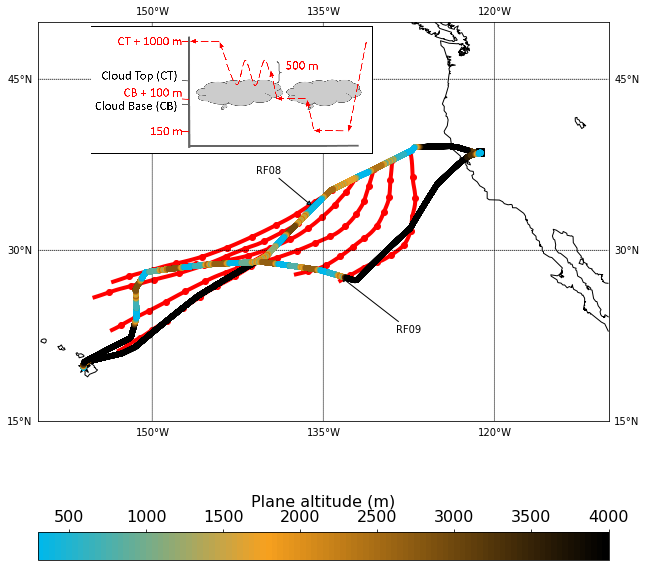

In [24]:
if True:
    if True:
#     missions = [
#                ,
# #                 ('rf10', 'rf11')
#                 ]
        m =  ('rf08', 'rf09')
#     for m in missions:
        out_nc = glob.glob(os.path.join(cu.CSET_flight_dir, '{}*.nc'.format(m[0].upper())))[0]
        ret_nc = glob.glob(os.path.join(cu.CSET_flight_dir, '{}*.nc'.format(m[1].upper())))[0]
        saus = os.path.join(cu.sausage_dir, '{}_{}'.format(m[0], m[1]))
        flightplan = cu.load_flight_file(saus)
        print(flightplan['name'])

        # read in outbound and return flight data
        with nc4.Dataset(out_nc, 'r') as flt_nc:
            out_lats = flt_nc.variables['LATC'][:].copy()
            out_lons = flt_nc.variables['LONC'][:].copy()
            out_alt = flt_nc.variables['ALT'][:].copy()
            timevar = flt_nc.variables['Time']
            out_date = nc4.num2date(timevar[:], units=timevar.units)
        out_fp = {'lats': out_lats, 'lons': out_lons, 'time': out_date,
                  'alt': out_alt}
        with nc4.Dataset(ret_nc, 'r') as flt_nc:
            ret_lats = flt_nc.variables['LATC'][:].copy()
            ret_lons = flt_nc.variables['LONC'][:].copy()
            ret_alt = flt_nc.variables['ALT'][:].copy()
            timevar = flt_nc.variables['Time']
            ret_date = nc4.num2date(timevar[:], units=timevar.units)
#         if isinstance(ret_lats, np.ma.core.MaskedArray):
#             m = np.logical_or(ret_lats.mask, ret_lons.mask)
#             ret_lats = ret_lats.data[~m]
#             ret_lons = ret_lons.data[~m]
#             ret_alt = ret_alt.data[~m]
#             ret_date = ret_date[~m]
        ret_fp = {'lats': ret_lats, 'lons': ret_lons, 'time': ret_date,
                  'alt': ret_alt}

        tlist = gen_final_traj(flightplan, regen=False)
        tlist_drop = [tlist[i] for i, n in enumerate(flightplan['labels']) if
                      n not in flightplan['drop']]
        out_labels = flightplan['labels']
        floc = '/home/disk/eos4/jkcm/Data/CSET/Trajectories/{}_waypoints'
        b_labels, b_waypts = read_b_waypt(flightplan, floc.format('b'))

        outfile_b = os.path.join(cu.flight_trajs,
                                flightplan['name'] + '_b_waypoints.png')
        fig, ax = new_final_traj_plot(flightplan['name'], tlist, out_labels, out_fp, ret_fp,
                       outfile_b, b_waypts, b_labels)
        out_i = 10000
        ax.annotate('RF08', xy=(out_lons[out_i], out_lats[out_i]), xytext = (out_lons[out_i]-5, out_lats[out_i]+3), xycoords='data',
                    textcoords='data', arrowprops={"arrowstyle": "-|>"})
        ret_i = 20000
        ax.annotate('RF09', xy=(ret_lons[ret_i], ret_lats[ret_i]), xytext = (ret_lons[ret_i]+5, ret_lats[ret_i]-5), xycoords='data',
                    textcoords='data', arrowprops={"arrowstyle": "-|>"})
                    
        img=mpimg.imread(os.path.join(cu.plot_dir, "CSET_insert.png"))
        ax_im = inset_axes(ax, width="100%", height='100%',
                    bbox_to_anchor=[0.1, 0.6, 0.5, 0.5], bbox_transform=ax.transAxes)
#         ax_im.set_facecolor('white')
        mgplot = ax_im.imshow(img)
        ax_im.axis('off')
        
        
        fig.savefig(os.path.join(cu.plot_dir, "1_RF08_pair_map.png"), dpi=600, bbox_inches='tight')

# labels[i], xy=(x, y), xytext=(x-1, y+1), xycoords='data',
# #                         textcoords='data', color='w', fontsize=8,
# #                         backgroundcolor=(0, 0, 0, 0.85))


In [139]:
fig.get_size_inches()

array([4.5, 5. ])